In [1]:
import Pkg; Pkg.add("GridapGmsh")
using Gridap
using GridapGmsh
using LinearAlgebra
using Plots
using DifferentialEquations
using LaTeXStrings

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


Import the Mesh to a model and get the nodes and elements

In [2]:
model = GmshDiscreteModel("accuratedoor.msh")
nodes = model.grid.node_coordinates

Info    : Reading 'accuratedoor.msh'...
Info    : 9 entities
Info    : 295 nodes
Info    : 520 elements
Info    : Done reading 'accuratedoor.msh'


295-element Vector{VectorValue{2, Float64}}:
                             VectorValue{2, Float64}(0.0, 0.0)
                            VectorValue{2, Float64}(83.0, 0.0)
                          VectorValue{2, Float64}(83.0, 250.0)
                           VectorValue{2, Float64}(0.0, 250.0)
                VectorValue{2, Float64}(9.22222222218795, 0.0)
               VectorValue{2, Float64}(18.44444444437005, 0.0)
               VectorValue{2, Float64}(27.66666666655214, 0.0)
               VectorValue{2, Float64}(36.88888888873424, 0.0)
               VectorValue{2, Float64}(46.11111111095582, 0.0)
               VectorValue{2, Float64}(55.33333333321686, 0.0)
                                      ⋮
 VectorValue{2, Float64}(6.579436733260907, 6.815233629324782)
 VectorValue{2, Float64}(63.94022183835568, 236.6497274260363)
 VectorValue{2, Float64}(14.33049216485654, 210.0056293480986)
 VectorValue{2, Float64}(76.26441579748341, 243.5887295980461)
 VectorValue{2, Float64}(14.45680

In [3]:
elements = model.grid.cell_node_ids

520-element Gridap.Arrays.Table{Int32, Vector{Int32}, Vector{Int32}}:
 [35, 36, 162]
 [87, 160, 161]
 [248, 256, 292]
 [175, 245, 260]
 [87, 160, 168]
 [35, 87, 162]
 [143, 169, 237]
 [93, 256, 292]
 [191, 230, 247]
 [87, 161, 162]
 ⋮
 [162, 261, 288]
 [157, 263, 295]
 [74, 278, 284]
 [37, 261, 290]
 [69, 260, 293]
 [137, 269, 273]
 [144, 271, 279]
 [86, 263, 295]
 [188, 278, 284]

Get all the areas of the elements

In [4]:
Areas = zeros(length(elements))
A = 0
for (i, element) in enumerate(elements)
    area = 0
    for j in 1:length(element)
        k = j % length(element) + 1
        area += nodes[element[j]][1] * nodes[element[k]][2] - nodes[element[j]][2] * nodes[element[k]][1]
    end 
    Areas[i] = abs(area)/2  

end
println(Areas)
println(sum(Areas))
println(length)


[51.17528927807325, 46.69528813849229, 41.36355600929278, 37.570561536296594, 48.26090716026465, 51.56841494493801, 48.370172808189636, 38.51589050849657, 45.30440858362999, 50.48527743996419, 47.244963888373604, 34.927717155764185, 36.80781613253771, 47.41516632379353, 48.23055053076496, 43.07070708494564, 47.06304759789782, 49.33416107714311, 38.2791385164046, 41.16838069995049, 45.38835630558788, 32.50555829227085, 46.338018961967464, 39.040466755846865, 45.27352470165624, 43.75252442855708, 38.37046778789394, 37.375957778594056, 48.13522930216277, 44.852183764283836, 45.35739095316967, 39.86047042262294, 45.08976967437229, 43.80850954081052, 38.91243950920011, 46.23954627734838, 45.207816479504345, 37.56675100905227, 45.286417575461655, 44.30699400512776, 44.69453713657913, 38.597141291879666, 44.188622941066114, 44.29093053142333, 36.00858636518933, 38.171577097617956, 39.28418023871143, 44.1725736069468, 38.57606465953904, 44.1994038034959, 47.39665523746862, 43.4388609417656, 37

Define the F funtion

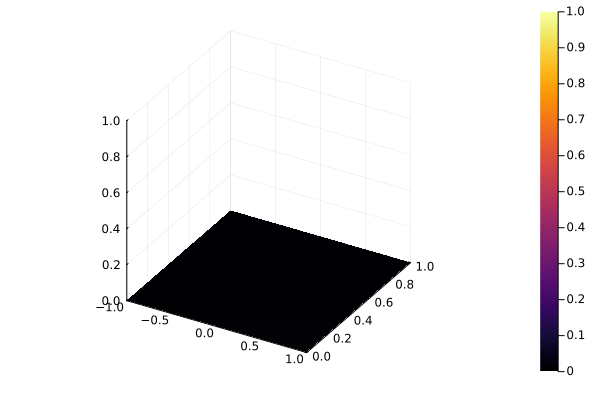

In [5]:
function load(x, y, t)
    x0 = 42    
    y0 = 125
    sigmax = 1
    sigmay = 1
    return exp(-(((x-x0)^2)/(2*sigmax^2) + (y-y0)^2/(2*sigmay^2)))
    # return float(x == 0 && y == 0)
end

# matlab: meshgrid function:
function meshgrid(xin,yin)
    nx=length(xin)
    ny=length(yin)
    xout=zeros(ny,nx)
    yout=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            xout[ix,jx]=xin[jx]
            yout[ix,jx]=yin[ix]
        end
    end
    return (x=xout, y=yout)
end

# Plotting the load:
x = LinRange(-1,1,15)
y = LinRange(0, 1,15)
X,Y  = meshgrid(x,y)
fvalues = load.(X, Y, 0)

surface(X,Y,fvalues)


Compute the K matrix

In [6]:
N = length(nodes)
Ke = zeros(3,3)
K = zeros(N,N)
F = zeros(N)
for (index,element) in enumerate(elements)
    COORDS = []
    for nd in element
        xi, yi= nodes[nd]
        COORDS = vcat(COORDS, [xi, yi, 1])
    end
    COORDS = transpose(reshape(COORDS, 3, 3))
    ABC = inv(float.(COORDS))

    for i in 1:3
        for j in 1:3
            Ke[i,j] = ABC[1,i]*ABC[1,j] + ABC[2, i]*ABC[2, j]
        end
    end

    Ke = Ke * Areas[index]

    for (local_i, real_i) in enumerate(element)
        for (local_j, real_j) in enumerate(element)
            K[real_i, real_j]+= Ke[local_i, local_j]
        end
    end

    # F, LOAD VECTOR
    for (local_i, global_i) in enumerate(element)
        fe = zeros(3)
        for (k,nd) in enumerate(element)
            xi,yi = nodes[nd]
            fe[k] = load(xi, yi, 0)
        end
        F[global_i] += fe[local_i] * Areas[index]/3
    end

end

display(K)
display(F)

295×295 Matrix{Float64}:
  0.831113  0.0        0.0       0.0       …  0.0      0.0      0.0
  0.0       0.832459   0.0       0.0          0.0      0.0      0.0
  0.0       0.0        0.832272  0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.831129     0.0      0.0      0.0
 -0.231174  0.0        0.0       0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0       …  0.0      0.0      0.0
  0.0       0.0        0.0       0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0          0.0      0.0      0.0
  ⋮                                        ⋱                    
 -0.435912  0.0        0.0       0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0          0.0      0.0      0.0
  0.0       0.0       -0.4

295-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

#### Reduced Stiffness Matrix and Load Vector with Boundary Conditions

Let:

- ``BC_nodes``:vector with the local numbering of the nodes that have Dirichlet boundary conditions.

- ``BC_values``: vector of the values of the actual boundary conditions.

In [7]:
print(sort([[nodes[i], i] for i in 1:N ]))

Vector{Number}[[(0.0, 0.0), 1], [(9.22222222218795, 0.0), 5], [(18.44444444437005, 0.0), 6], [(27.66666666655214, 0.0), 7], [(36.88888888873424, 0.0), 8], [(46.11111111095582, 0.0), 9], [(55.33333333321686, 0.0), 10], [(64.55555555547791, 0.0), 11], [(73.77777777773895, 0.0), 12], [(83.0, 0.0), 2], [(76.45688391124057, 6.574994662258369), 285], [(6.579436733260907, 6.815233629324782), 287], [(68.87118751820776, 7.089678031684164), 255], [(51.00644118093989, 7.521857687984918), 240], [(41.95712577705616, 7.608912405702185), 69], [(14.00058502127822, 7.692136559579726), 253], [(22.71058763327436, 7.817909424411146), 91], [(59.9444444443474, 7.986678723823438), 88], [(32.40292783384469, 9.50137391021537), 245], [(83.0, 9.999999999994456), 13], [(0.0, 9.999999999999375), 68], [(64.72860765745719, 13.09513863752405), 294], [(46.11111111094902, 13.38714270982943), 293], [(73.79764563212366, 14.64335113673226), 92], [(25.83690940374496, 15.15130873573609), 272], [(18.2913390089495, 15.3896348

 204.2912589398168), 166], [(74.05236842502255, 204.8778975393825), 78], [(8.347143804544308, 205.0265591375531), 184], [(29.49952733994278, 208.8288326725382), 148], [(46.60489521426775, 209.0355009203216), 133], [(64.19524811108727, 209.4178765712143), 167], [(83.0, 209.9999999999854), 33], [(0.0, 210.0000000000027), 48], [(14.33049216485654, 210.0056293480986), 289], [(37.97990550993961, 213.8965288966146), 134], [(55.03442646019592, 214.0815070081813), 146], [(21.52761795698024, 214.1467404364548), 163], [(73.55100722232854, 214.7293043298537), 168], [(8.660254037843796, 215.0000000000023), 84], [(29.35111157909981, 218.6805463704158), 149], [(46.43714276036363, 218.8851036351621), 138], [(63.79453842082559, 219.3224678289759), 160], [(14.45680771959934, 219.8889732514872), 291], [(83.0, 219.999999999989), 34], [(0.0, 220.000000000002), 47], [(37.768007339534, 223.517414085675), 173], [(54.88426368103087, 223.8663007353956), 153], [(21.54743488783971, 224.0425676698829), 164], [(73

In [8]:
BC_nodes  = [1, 3, 4, 37, 38, 39, 40, 41, 42, 43, 44]
BC_values = zeros(length(BC_nodes))

for i in 1:N
    if i in BC_nodes
        K[i,:] = zeros(N)
        K[i,i] = 1
        index = findfirst.(isequal.(i), (BC_nodes,))
        F[i] = BC_values[Int(index[1])]
    end
end
display(K)
display(F)

295×295 Matrix{Float64}:
  1.0       0.0        0.0       0.0   0.0       …  0.0      0.0      0.0
  0.0       0.832459   0.0       0.0   0.0          0.0      0.0      0.0
  0.0       0.0        1.0       0.0   0.0          0.0      0.0      0.0
  0.0       0.0        0.0       1.0   0.0          0.0      0.0      0.0
 -0.231174  0.0        0.0       0.0   1.79798      0.0      0.0      0.0
  0.0       0.0        0.0       0.0  -0.267376  …  0.0      0.0      0.0
  0.0       0.0        0.0       0.0   0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0   0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0   0.0          0.0      0.0      0.0
  0.0       0.0        0.0       0.0   0.0          0.0      0.0      0.0
  ⋮                                              ⋱                    
 -0.435912  0.0        0.0       0.0  -0.881668     0.0      0.0      0.0
  0.0       0.0        0.0       0.0   0.0          0.0      0.0      0.0
  0.0       0.0 

295-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

#### First time dependent approximation `K*c = F(x,y,t)`

In [9]:
# Time parameters
t0 = 0
dt = 0.1
tf = 1
times = Vector(t0:dt:tf)
# Array with the solution: rows are the components, columns are timesteps
U = zeros(N,length(times))

for (t_index,t) in enumerate(times)
    # Defining the F vector for each time step:
    for (e_index,element) in enumerate(elements)
        for (local_i, global_i) in enumerate(element)
            fe = zeros(3)
            for (k,nd) in enumerate(element)
                xi,yi = nodes[nd]
                fe[k] = load(xi, yi, 0)
            end
            F[global_i] += fe[local_i] * Areas[e_index]/3
        end
    end
    # Reducing the F vector for each timestep (K is already reduced):
    for i in 1:N
        if i in BC_nodes
            bc_index = findfirst.(isequal.(i), (BC_nodes,))
            F[i] = BC_values[Int(bc_index[1])]
        end
    end

    c = K\F

end


## Simple `K*c=F` solution and plot

In [10]:
c = K\F

295-element Vector{Float64}:
  0.0
 45.19529769239679
  0.0
  0.0
 23.338295650814427
 31.72826850046237
 36.49075147498424
 39.64762435500893
 41.86982881406776
 43.40740340836859
  ⋮
 23.74479295249684
  7.030541678479293
 21.12186845615293
  3.3747288041954993
 15.900093744567895
 10.551510440846998
 42.54586600168692
 44.87292852124533
 36.78999091147666

In [11]:
function get_XY_nodes(nodes)
    N = size(nodes)[1]
    X = zeros(N)
    Y = zeros(N)
    for k in 1:N    
        X[k], Y[k] = nodes[k]
    end
    return X,Y
end
xvec, yvec = get_XY_nodes(nodes)
print("Done")

Done

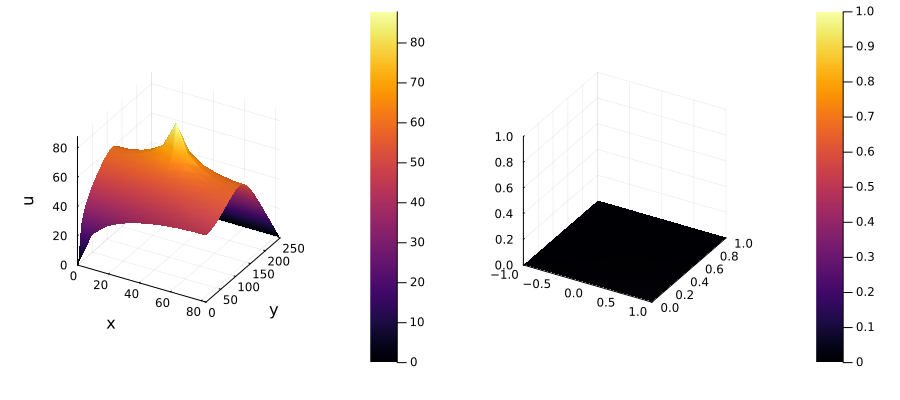

In [12]:
p1 = surface(xvec,yvec,c,st=:surface)
xlabel!("x")
ylabel!("y")
zlabel!("u")

x = LinRange(-1,1,50)
y = LinRange(0, 1,50)
X,Y  = meshgrid(x,y)
fvalues = load.(X, Y, 0)
p2 = surface(X,Y,fvalues)
plot(p1,p2, layout=(1,2), size=(900,400))

# TIME DEPENDENT PROBLEM

Create M matrix

In [13]:
M = zeros(N,N)
for (index,element) in enumerate(elements)
    Me = I(3)
    Me = Me*Areas[index]/3
    #display(Me)
    for (local_i, real_i) in enumerate(element)
        M[real_i, real_i]+= Me[local_i, local_i]
    end
end
display(M)

295×295 Matrix{Float64}:
 21.441   0.0      0.0      0.0     …   0.0      0.0      0.0      0.0
  0.0    21.0112   0.0      0.0         0.0      0.0      0.0      0.0
  0.0     0.0     21.0803   0.0         0.0      0.0      0.0      0.0
  0.0     0.0      0.0     21.4332      0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0     …   0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
  ⋮                                 ⋱                             
  0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0     0.0      0.0      0.0         0.0      0.0    

Damping Matrix

In [14]:
alpha = 0.1
beta  = 0.0
C = alpha * M + beta * K
display(C)

295×295 Matrix{Float64}:
 2.1441  0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0     2.10112  0.0      0.0         0.0      0.0      0.0      0.0
 0.0     0.0      2.10803  0.0         0.0      0.0      0.0      0.0
 0.0     0.0      0.0      2.14332     0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
 ⋮                                  ⋱                             
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0     0.0      0.0      0.0         0.0      0.0      0.0      0.

In [15]:
function load(x, y, t)
    x0 = 42
    y0 = 125
    sigmax = 10
    sigmay = 5
    if t > 1 && t < 70
        return cos(x-x0)*cos(y-y0) * exp(3-t) # apply wave force
    end
    return 0
end

function bigF(t)
    bigD = zeros(N)
    for k in 1:N
        bigD[k] = load(xvec[k],yvec[k],t)
    end
    for x in BC_nodes
        bigD[x] = 0
    end
    return bigD
end


#..define the right-hand side of the ordinary differential equation of the equation of motion 
function CompleteProblem!(ddu,du,u,p,t)
    # ddu .= (-K*u .-C.*du + F)#.*inv(M)
    ddutemp = inv(M) * (bigF(t) - K*u - C*du)

    for i in 1:length(ddutemp)
        ddu[i]= ddutemp[i]
    end
end

#..set initial position and velocity
u0 = zeros(N)
# u0[8] = .2

v0 = zeros(N)
                                    
#..set time begin and end forward
tspan = (0.0,1000.0)           

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(CompleteProblem!,v0,u0,tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob)


#..plot the source term
tvec = Vector(0.:0.01:10.)
#fvec = f.(tvec)
# p1 = plot(tvec,fvec,label="Excitation")


#..velocity and position have vars=(1,2) and vars=(3,4), respectively. 
plot(sol,vars=1)
for i in 2:N-1
    plot!(sol,vars=i)
end
p1 = plot!(sol,vars=N)

plot(sol,vars=N+1)
for i in N+2:2*N-1
    plot!(sol,vars=i)
end
p2 = plot!(sol,vars=2*N)


#..plot solution of velocity and position as function of time  
plot(p1,p2,layout=(2,1))

my_matrix = zeros(N, N)

for i in 1:N
    for j in 1:N
        my_matrix[i, j] = sol.u[1][j]
    end
end

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


In [16]:
#to verify the boundaries conditions 
# clamped nodes: 1, 3, 4, 37, 38, 39, 40, 41, 42, 43, 44 (generalize: TBD)
matrix_clamped = []
for time in 1:length(sol.t)   
    for j in [1, 3, 4, 37, 38, 39, 40, 41, 42, 43, 44]
        append!(matrix_clamped, sol.u[time][j])
        if sol.u[time][j] != 0
            print("Found")
        end
    end
end

print(matrix_clamped)
size(matrix_clamped)
#without printing everything, how can I look for elements different than 0?

Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

(1683,)

Create animation with force and damping and save to gif

┌ Info: Saved animation to /home/kkasper1/Athens/LGI_anim.gif
└ @ Plots /home/kkasper1/.julia/packages/Plots/B5j7d/src/animation.jl:156


Plots.AnimatedGif("/home/kkasper1/Athens/LGI_anim.gif")
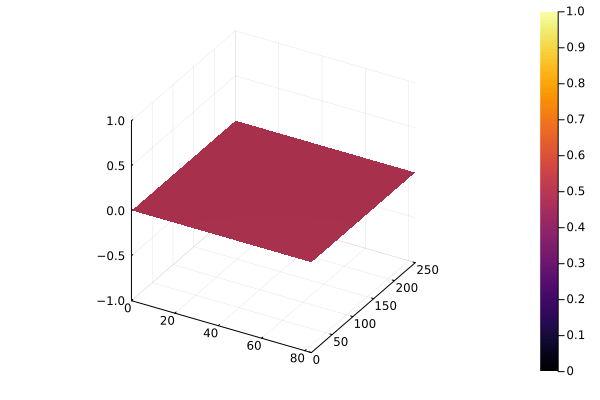

In [17]:

anim = @animate for it = 1:length(sol.t)
    surface(xvec,yvec,sol.u[it][N+1:N*2],plotstyle="pm3d")
    zlims!(-1, 1)
end
gif(anim, "LGI_anim.gif", fps = 10)